In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import pingouin as pg
sns.set_theme(
    style="whitegrid",
    rc={"figure.figsize": (7, 3.5)}
)

In [5]:
df = pd.read_csv('4_experiment_lesson.csv', encoding='utf-8')

•	order_id - id заказа  
•	delivery_time - время доставки в минутах  
•	district - район доставки  
•	experiment_group - экспериментальная группа  

In [6]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.3+ KB


In [8]:
df.describe()

,order_id,delivery_time
count,20196.000000,20196.000000
mean,11103.503565,42.054169
std,5835.424404,10.382196
min,1000.000000,10.000000
25%,6048.750000,35.000000
50%,11109.500000,42.000000
75%,16158.250000,49.000000
max,21207.000000,83.000000


In [9]:
df.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).  
У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности.   
Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой.   
Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров  

Для начала давайте сформулируем гипотезы для проверки. Выберите статистические гипотезы, которые мы сможем проверить на этом эксперименте:
- Н0: Разницы между средним временем доставки в тестовой и контрольной группу нет
- Н1: Разница между средним временем доставки в тестовой и контрольной группе есть

Составте графики распределения для контрольной и экспериментальной группы

district
Central     Axes(0.125,0.11;0.775x0.77)
Purlieus    Axes(0.125,0.11;0.775x0.77)
Suburb      Axes(0.125,0.11;0.775x0.77)
Name: delivery_time, dtype: object

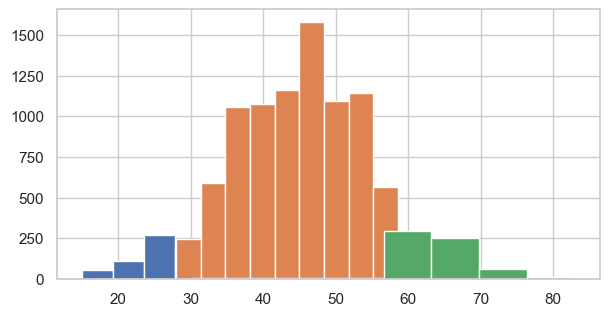

In [19]:
df[df['experiment_group']=='control'].groupby('district').delivery_time.hist()

district
Central     Axes(0.125,0.11;0.775x0.77)
Purlieus    Axes(0.125,0.11;0.775x0.77)
Suburb      Axes(0.125,0.11;0.775x0.77)
Name: delivery_time, dtype: object

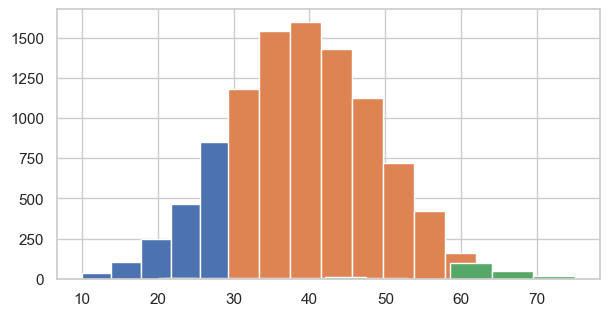

In [20]:
df[df['experiment_group']=='test'].groupby('district').delivery_time.hist()

<Axes: xlabel='delivery_time', ylabel='Count'>

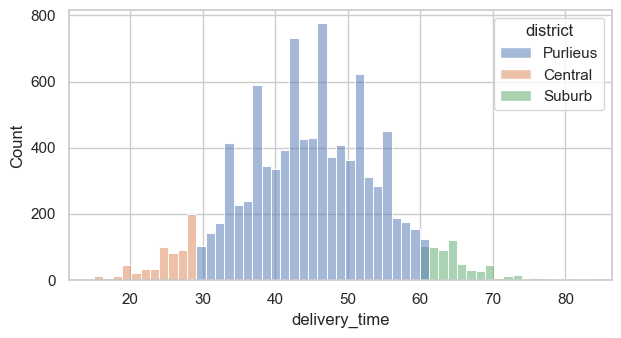

In [23]:
sns.histplot(df[df['experiment_group']=='control'], x="delivery_time", hue="district")

<Axes: xlabel='delivery_time', ylabel='Count'>

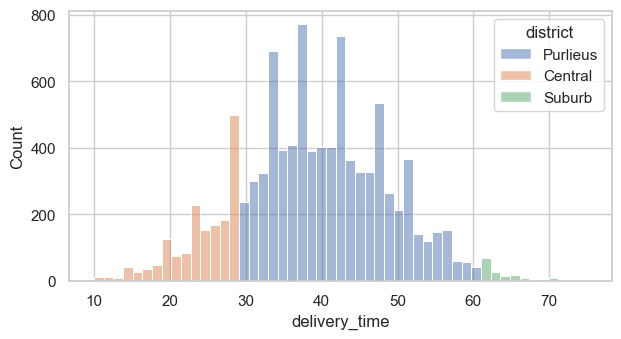

In [21]:
sns.histplot(df[df['experiment_group']=='test'], x="delivery_time", hue="district")

Посчитайте количество наблюдейний в тествовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [25]:
df[df['experiment_group']=='control'].order_id.count() - df[df['experiment_group']=='test'].order_id.count()

np.int64(-12)

Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.  
Вообще для выборок таких колоссальных размеров мы не обязаны это делать в отсутствие слишком уж выраженной асимметрии и выбросов в данных t-тест и так работать будет нормально, но посмотреть лишний раз всё равно можно.  
Обычно нормальность тестируют с помощью теста Шапиро-Уилка ( scipy, stats.shapiго()), однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности! Поэтому используйте функцию scipy stats.normaltest() - она больше адаптирована к большим выборкам.  
Также можете сделать это через пакет pingouin - вот этой функцией. Не забудьте выбрать правильный аргумент!  
NB! В прошлых версиях этого курса мы полагались на другой трюк - сэмплирование данных из каждой группы, чтобы обойти проблемы чувствительности теста. Метод не очень надёжный, поэтому мы от него в итоге отказались, но можете его попробовать по методу ниже! Впрочем, не интерпретируйте его результаты слишком серьезно.

In [26]:
df.groupby('experiment_group').delivery_time.std()

experiment_group
control    9.990017
test       9.883308
Name: delivery_time, dtype: float64

In [ ]:
# нормальность по Шапиро (плохо реагирует на выборки большого размера)
pg.normality(data=df, dv='delivery_time', group='experiment_group')

c:\Users\MedTech\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10092.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\MedTech\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10104.
  res = hypotest_fun_out(*samples, **kwds)


,W,pval,normal
experiment_group,,,
control,0.998709,2.809902e-07,False
test,0.998619,1.073905e-07,False


In [28]:
# нормальность по альтернативному тесту
pg.normality(data=df, dv='delivery_time', group='experiment_group', method='normaltest')

,W,pval,normal
experiment_group,,,
control,0.253498,0.880955,True
test,7.024157,0.029835,False


In [30]:
# вариант с сэмплированием
st.shapiro(df[df['experiment_group']=='control'].delivery_time.sample(1000, random_state=17))

ShapiroResult(statistic=np.float64(0.9974716381542054), pvalue=np.float64(0.12392829880543466))

In [ ]:
st.shapiro(df[df['experiment_group']=='test'].delivery_time.sample(1000, random_state=17))

ShapiroResult(statistic=np.float64(0.9975429485383064), pvalue=np.float64(0.13902241238486684))

<Axes: ylabel='Count'>

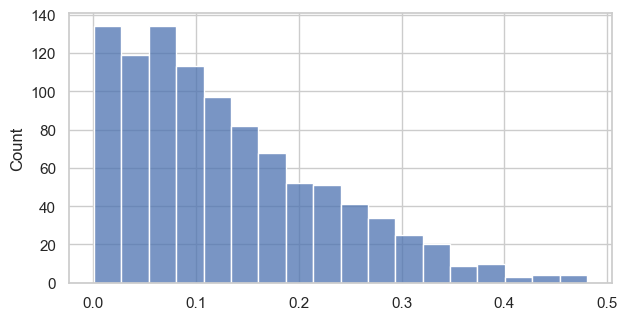

In [34]:
pvals = []
for _ in range(1000):
    res=st.shapiro(df[df['experiment_group']=='test'].delivery_time.sample(1000))
    pvals.append(res.pvalue)
sns.histplot(x=pvals)

In [ ]:
np.sum(np.array(pvals)<0.05) / len(pvals) # завышенная вероятность ошибки 1 рода

np.float64(0.236)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

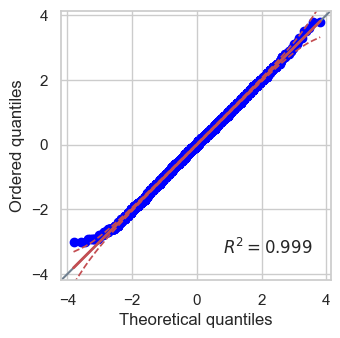

In [41]:
pg.qqplot(df[df['experiment_group']=='control'].delivery_time)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

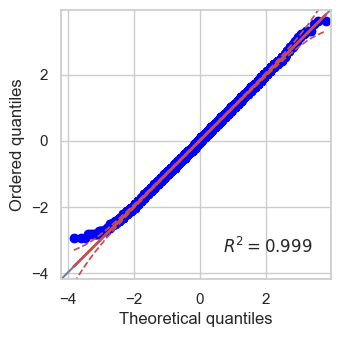

In [42]:
pg.qqplot(df[df['experiment_group']=='test'].delivery_time)

Сравниваем средние значения в тесте и контроле. 

In [43]:
st.ttest_ind(a=df[df['experiment_group']=='test'].delivery_time,
             b=df[df['experiment_group']=='control'].delivery_time)

TtestResult(statistic=np.float64(-43.03582663183714), pvalue=np.float64(0.0), df=np.float64(20194.0))

In [ ]:
pg.ttest(x=df[df['experiment_group']=='test'].delivery_time,
         y=df[df['experiment_group']=='control'].delivery_time)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-43.035552,20191.127788,two-sided,0.0,"[-6.29, -5.74]",0.605658,inf,1.0


In [50]:
# Манн-Уитни
st.mannwhitneyu(x=df[df['experiment_group']=='test'].delivery_time,
         y=df[df['experiment_group']=='control'].delivery_time)

MannwhitneyuResult(statistic=np.float64(33985060.0), pvalue=np.float64(0.0))

In [ ]:
# Yuen t-test - выкидывает определенное ко-во значиений из начала и из конца распределения (аномальные выбросы)
st.ttest_ind(a=df[df['experiment_group']=='test'].delivery_time,
         b=df[df['experiment_group']=='control'].delivery_time, trim=0.2)

TtestResult(statistic=np.float64(-42.16055367343425), pvalue=np.float64(0.0), df=np.float64(12118.0))

In [ ]:
# permutation t-test - случайным образом перемешиваем данные в распределении
st.ttest_ind(a=df[df['experiment_group']=='test'].delivery_time,
         b=df[df['experiment_group']=='control'].delivery_time, permutations=1000)

C:\Users\MedTech\AppData\Local\Temp\ipykernel_2316\83643242.py:2: DeprecationWarning: Arguments {'permutations'} are deprecated, whether passed by position or keyword. They will be removed in SciPy 1.17.0. Use ``method`` to perform a permutation test.
  st.ttest_ind(a=df[df['experiment_group']=='test'].delivery_time,


TtestResult(statistic=np.float64(-43.03582663183714), pvalue=np.float64(0.000999000999000999), df=np.float64(nan))

На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной

In [61]:
(1 - (df[df['experiment_group']=='control'].delivery_time.mean() / df[df['experiment_group']=='test'].delivery_time.mean())) * 100

np.float64(-15.413006702382305)